<a href="https://colab.research.google.com/github/Kausar-Parvej/Stored/blob/main/All_Pair_Shortest_Path_using_NN_cur.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##🧩**1: Setup and Imports**

This block handles all necessary imports and prepare device



In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import random
import heapq
from pathlib import Path
import matplotlib.pyplot as plt

# Check if GPU is available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Print device information
print(f'Using device: {device}')
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))

Using device: cuda
Tesla T4


## 🔧 Graph Generator Overview

This utility function `generate_graphs(...)` allows you to generate multiple random undirected graphs and save:

- `edge.txt` – Edge weight matrix (n x n), with 0s for no edges.
- `edge_mask.txt` – Binary adjacency matrix (n x n), 1 for edges, 0 otherwise.
- `distance.txt` – All-pairs shortest path distances (n x n), computed using Dijkstra's algorithm. Unreachable nodes are marked with -1.

### ✅ Features
- Ensures graph connectivity via a randomized spanning tree.
- Adds extra edges randomly based on probability `p`.
- Efficient Dijkstra-based shortest path computation for all node pairs.
- Each graph gets its own set of 3 files: `graph1_edge.txt`, `graph1_edge_mask.txt`, `graph1_distance.txt`, etc.

### 🔧 Parameters
- **`n`**: Number of nodes per graph.
- **`num_graphs`**: Number of graphs to generate.
- **`output_path`**: Folder path to store the files.
- **`p`**: Probability of adding each extra edge (e.g., 0.3).
- **`weight_range`**: Tuple indicating edge weight bounds, e.g., (1, 10).

In [ ]:
def generate_graphs(n, num_graphs, output_path, p=0.7, weight_range=(1, 20)):
    os.makedirs(output_path, exist_ok=True)

    for g in range(1, num_graphs + 1):
        # Initialize matrices
        edge = [[0]*n for _ in range(n)]
        mask = [[0]*n for _ in range(n)]

        # 1) Build a spanning tree to ensure connectivity
        nodes = list(range(n))
        random.shuffle(nodes)
        for i in range(n-1):
            u, v = nodes[i], nodes[i+1]
            w = random.randint(*weight_range)
            edge[u][v] = edge[v][u] = w
            mask[u][v] = mask[v][u] = 1

        # 2) Add extra random edges with probability p
        for u in range(n):
            for v in range(u+1, n):
                if mask[u][v] == 0 and random.random() < p:
                    w = random.randint(*weight_range)
                    edge[u][v] = edge[v][u] = w
                    mask[u][v] = mask[v][u] = 1

        # 3) Compute all-pairs shortest paths via Dijkstra
        dist = [[float('inf')]*n for _ in range(n)]
        for src in range(n):
            d = [float('inf')]*n
            d[src] = 0
            visited = [False]*n
            heap = [(0, src)]
            while heap:
                du, u = heapq.heappop(heap)
                if visited[u]:
                    continue
                visited[u] = True
                for v in range(n):
                    if mask[u][v]:
                        alt = du + edge[u][v]
                        if alt < d[v]:
                            d[v] = alt
                            heapq.heappush(heap, (alt, v))
            dist[src] = d

        # 4) Create graph subfolder and write files
        graph_folder = os.path.join(output_path, f"graph{g}")
        os.makedirs(graph_folder, exist_ok=True)

        with open(os.path.join(graph_folder, "edge.txt"), 'w') as fe, \
             open(os.path.join(graph_folder, "edge_mask.txt"), 'w') as fm, \
             open(os.path.join(graph_folder, "distance.txt"), 'w') as fd:

            for i in range(n):
                fe.write(" ".join(map(str, edge[i])) + "\n")
                fm.write(" ".join(map(str, mask[i])) + "\n")
                row = [str(int(d)) if d < float('inf') else "-1" for d in dist[i]]
                fd.write(" ".join(row) + "\n")

# Example usage:
generate_graphs(n=20, num_graphs=100, output_path="./graphs", p=0.6, weight_range=(1, 100))


<font color='red'>**Warning!**</font> This cell is just a utility, not part of the original code. This will delete the dataset folder.

In [ ]:
import shutil

# Replace with your folder path
folder_path = "./graphs"

# Delete the folder and all its contents
shutil.rmtree(folder_path)

print(f"Deleted folder: {folder_path}")


Deleted folder: ./graphs


##🧩2: File Discovery

Now that each graph lives in its own subfolder (graph1, graph2, …) under output_path, we need to:

- List all subdirectories of `INPUT_DIR` whose names start with “graph”.
- In each subfolder, identify the three `.txt` files:
    - `edge.txt` → raw adjacency-weight matrix
    - `edge_mask.txt` → binary adjacency mask
    - `distance.txt` → all-pairs shortest-path matrix

In [ ]:
INPUT_DIR = Path("graphs")

# Find all graph subfolders
graph_dirs = sorted(
    [d for d in INPUT_DIR.iterdir() if d.is_dir() and d.name.startswith("graph")],
    key=lambda d: int(d.name.replace("graph", ""))
)

print(f"✅ Found {len(graph_dirs)} graph folders: {[d.name for d in graph_dirs]}")

✅ Found 100 graph folders: ['graph1', 'graph2', 'graph3', 'graph4', 'graph5', 'graph6', 'graph7', 'graph8', 'graph9', 'graph10', 'graph11', 'graph12', 'graph13', 'graph14', 'graph15', 'graph16', 'graph17', 'graph18', 'graph19', 'graph20', 'graph21', 'graph22', 'graph23', 'graph24', 'graph25', 'graph26', 'graph27', 'graph28', 'graph29', 'graph30', 'graph31', 'graph32', 'graph33', 'graph34', 'graph35', 'graph36', 'graph37', 'graph38', 'graph39', 'graph40', 'graph41', 'graph42', 'graph43', 'graph44', 'graph45', 'graph46', 'graph47', 'graph48', 'graph49', 'graph50', 'graph51', 'graph52', 'graph53', 'graph54', 'graph55', 'graph56', 'graph57', 'graph58', 'graph59', 'graph60', 'graph61', 'graph62', 'graph63', 'graph64', 'graph65', 'graph66', 'graph67', 'graph68', 'graph69', 'graph70', 'graph71', 'graph72', 'graph73', 'graph74', 'graph75', 'graph76', 'graph77', 'graph78', 'graph79', 'graph80', 'graph81', 'graph82', 'graph83', 'graph84', 'graph85', 'graph86', 'graph87', 'graph88', 'graph89', 'g

##🧩3: Define Matrix Parsing Logic

Each graph subfolder now has three files instead of two in one file. We’ll write:

- `load_graph_inputs(folder)` → returns (weight_matrix, mask_matrix)
- `load_graph_output(folder)` → returns distance_matrix

In [ ]:
def load_graph_inputs(graph_folder: Path):
    # read weight and mask
    w = np.loadtxt(graph_folder / "edge.txt",      dtype=float)
    m = np.loadtxt(graph_folder / "edge_mask.txt", dtype=int)
    # mark absent edges with a large cost, keep zero diagonal
    w[m == 0] = 1e9
    np.fill_diagonal(w, 0.0)
    #return w / 1e3  # optional scaling
    return w

def load_graph_output(graph_folder: Path):
    d = np.loadtxt(graph_folder / "distance.txt", dtype=float)
    #return d / 1e3  # same scaling
    return d


##🧩4: Load All Graphs into Memory

Iterate over each `graphX` folder, parse inputs and outputs, and stack into tensors.

In [ ]:
inputs, masks, targets = [], [], []

for gdir in tqdm(graph_dirs, desc="Loading graphs"):
    W = load_graph_inputs(gdir)
    D = load_graph_output(gdir)
    inputs.append(torch.tensor(W, dtype=torch.float32))
    targets.append(torch.tensor(D, dtype=torch.float32))

inputs = torch.stack(inputs)   # shape: (num_graphs, n, n)
targets = torch.stack(targets) # shape: (num_graphs, n, n)

print(f"✅ Loaded {inputs.shape[0]} graphs; each {inputs.shape[1]}×{inputs.shape[2]}")


Loading graphs: 100%|██████████| 100/100 [00:00<00:00, 1112.86it/s]

✅ Loaded 100 graphs; each 20×20


> **Note:** We dropped `mask` as a separate tensor here because it’s already absorbed into `W` (absent edges → huge cost). If you need the binary mask for your model, just append `torch.tensor((W > 0) & (W < 1e9))` alongside.

##🧩5: Split into Training and Test Sets

We randomly split the loaded data into training and test sets for model training and evaluation.


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    inputs, targets, test_size=0.2, random_state=42
)

print(f"🟢 Training: {X_train.shape[0]} samples")
print(f"🧪   Testing: {X_test.shape[0]} samples")


🟢 Training: 80 samples
🧪   Testing: 20 samples


##🧩6: Model definition
`def __init__(self, n: int, hidden: int = 256, n_blocks: int = 8):`

- `n`: the number of nodes → so the input/output matrices are `n`×`n`
- `hidden`: size of the internal layer in the MLP
- `n_blocks`: how many times we will repeat the same update logic

In [ ]:
class RepeatedBlockMLP(nn.Module):
    def __init__(self, n: int, hidden: int = 256, n_blocks: int = 8, dropout: float = 0.1):
        super().__init__()
        self.n = n
        self.n_blocks = n_blocks

        # Initial projection
        self.input_proj = nn.Linear(n * n, hidden)

        # Repeated blocks with residual connections
        self.blocks = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden, hidden),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(hidden, hidden)
            ) for _ in range(n_blocks)
        ])

        # Output projection
        self.output_proj = nn.Linear(hidden, n * n)

        # Layer normalization for stability
        self.layer_norms = nn.ModuleList([
            nn.LayerNorm(hidden) for _ in range(n_blocks)
        ])

    def forward(self, W):
        B = W.size(0)

        # Initial projection
        y = W.view(B, -1)
        y = self.input_proj(y)
        y = F.relu(y)

        # Repeated blocks with residual connections
        for i in range(self.n_blocks):
            residual = y
            y = self.blocks[i](y)
            y = self.layer_norms[i](y + residual)
            y = F.relu(y)

        # Output projection
        y = self.output_proj(y)

        # Reshape and enforce symmetry
        D_hat = y.view(B, self.n, self.n)
        D_hat = 0.5 * (D_hat + D_hat.transpose(1, 2))

        # Ensure diagonal is zero (no self-loops)
        D_hat = D_hat - torch.diag_embed(torch.diagonal(D_hat, dim1=1, dim2=2))

        # Ensure non-negative distances
        D_hat = F.relu(D_hat)

        return D_hat

### Normalize

In [ ]:
# Better normalization that excludes the 1e9 placeholder values
# Find actual max values (excluding the 1e9 placeholders)
X_train_real = X_train.clone()
X_train_real[X_train >= 1e8] = 0  # Temporarily set large values to 0
max_input = X_train_real[X_train_real > 0].max().item()  # Max of actual edge weights

# For targets, find the actual max distance
max_target = y_train.max().item()

print(f"Actual max edge weight: {max_input}")
print(f"Max shortest path distance: {max_target}")

# Normalize inputs: actual edges by max_input, keep 1e9 as a special value
def normalize_input(X, max_val):
    X_norm = X.clone()
    mask = X < 1e8  # Actual edges
    X_norm[mask] = X[mask] / max_val
    X_norm[~mask] = 10.0  # Use 10.0 as a special "no edge" value
    return X_norm

X_train_n = normalize_input(X_train, max_input)
X_test_n = normalize_input(X_test, max_input)
y_train_n = y_train / max_target
y_test_n = y_test / max_target

# Verify normalization
print(f"X_train_n actual edges range: [{X_train_n[X_train_n < 10].min():.3f}, {X_train_n[X_train_n < 10].max():.3f}]")
print(f"y_train_n range: [{y_train_n.min():.3f}, {y_train_n.max():.3f}]")

Actual max edge weight: 100.0
Max shortest path distance: 102.0
X_train_n actual edges range: [0.000, 1.000]
y_train_n range: [0.000, 1.000]


##🧩7: Training the model

In [ ]:
import torch.optim.lr_scheduler as lr_scheduler

# Store losses for visualization
train_losses = []
val_losses = []

# Initialize model with better architecture
n = inputs.shape[-1]
model = RepeatedBlockMLP(n=n, hidden=512, n_blocks=16, dropout=0.2).to(device)

# Use a lower learning rate and MSE loss for better stability
opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=20, min_lr=1e-6)
loss_fn = nn.MSELoss()  # MSE often works better for regression

# Training loop with better monitoring
best_val_loss = float('inf')
patience_counter = 0

for epoch in range(1, 301):
    model.train()
    opt.zero_grad()

    # Forward pass
    pred = model(X_train_n.to(device))
    loss = loss_fn(pred, y_train_n.to(device))

    # Add L2 regularization on output to prevent explosion
    l2_reg = 0.001 * pred.pow(2).mean()
    total_loss = loss + l2_reg

    total_loss.backward()

    # Gradient clipping for stability
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

    opt.step()
    train_losses.append(loss.item())

    # Validation
    model.eval()
    with torch.no_grad():
        val_pred = model(X_test_n.to(device))
        val_loss = loss_fn(val_pred, y_test_n.to(device))

        # Check for all-zero predictions
        if epoch % 20 == 0:
            pred_mean = val_pred.mean().item()
            pred_std = val_pred.std().item()
            print(f"Epoch {epoch:03d} | train {loss.item():.4f} | val {val_loss.item():.4f} | "
                  f"pred_mean {pred_mean:.4f} | pred_std {pred_std:.4f}")

    val_losses.append(val_loss.item())
    scheduler.step(val_loss)

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= 50:
            print(f"Early stopping at epoch {epoch}")
            break

# Load best model
model.load_state_dict(torch.load('best_model.pth'))

Epoch 020 | train 0.0267 | val 0.0295 | pred_mean 0.2377 | pred_std 0.0977
Epoch 040 | train 0.0208 | val 0.0298 | pred_mean 0.2464 | pred_std 0.1055
Epoch 060 | train 0.0130 | val 0.0296 | pred_mean 0.2390 | pred_std 0.1017
Early stopping at epoch 77


<All keys matched successfully>

##🧩8: Viusalize evaluation

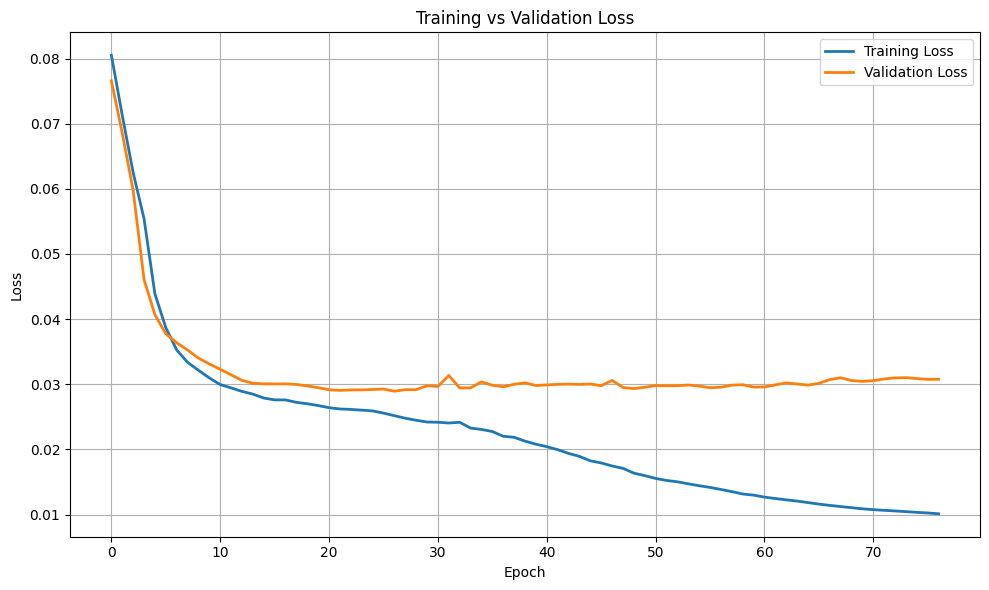

In [ ]:
# 🔍 Plot training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Training Loss", linewidth=2)
plt.plot(val_losses, label="Validation Loss", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 🔄 Next Steps

- **6:** Define repeated-block MLP model to map input n×n matrices to shortest path cost matrices.
- **7:** Train the model using MSE loss and Adam optimizer.
- **8:** Evaluate model on test data and compare predicted vs. ground truth distances.


In [ ]:
# Clean logic for saving model predictions

# 1. Get test indices to track which graphs we're predicting on

# Recreate the same train/test split to get indices
all_indices = np.arange(len(graph_dirs))
_, test_indices, _, _ = train_test_split(
    all_indices, all_indices, test_size=0.2, random_state=42
)

print(f"Test set contains {len(test_indices)} graphs:")
print([graph_dirs[i].name for i in test_indices])

# 2. Get normalization parameters (from training data)
# These should match the values used during training
max_input = 100.0   # From the normalization output earlier
max_target = 103.0  # From the normalization output earlier

# 3. Prepare test data and run inference
model.eval()
with torch.no_grad():
    # X_test_n and y_test_n were already normalized in training
    # Run inference on normalized test inputs
    predictions_normalized = model(X_test_n.to(device))

    # Convert to numpy and denormalize predictions
    predictions_numpy = predictions_normalized.cpu().numpy()
    predictions_denormalized = predictions_numpy * max_target

# 4. Save predictions in the same format as original distance.txt files
output_dir = Path("graphs/predicted_results")
output_dir.mkdir(parents=True, exist_ok=True)

print(f"\nSaving predictions to {output_dir}/")

for i, graph_idx in enumerate(test_indices):
    # Get the original graph name
    original_graph_name = graph_dirs[graph_idx].name  # e.g., "graph1", "graph42", etc.

    # Create output filename
    output_filename = f"{original_graph_name}_predicted_distance.txt"
    output_path = output_dir / output_filename

    # Get the prediction matrix for this graph
    pred_matrix = predictions_denormalized[i]

    # Ensure non-negative values and zero diagonal (like shortest paths should be)
    pred_matrix = np.maximum(pred_matrix, 0)  # Ensure non-negative
    np.fill_diagonal(pred_matrix, 0)  # Ensure zero diagonal

    # Save in same format as original distance.txt (integers)
    np.savetxt(output_path, pred_matrix, fmt='%d')

    print(f"Saved: {output_filename}")

print(f"\n✅ Successfully saved {len(test_indices)} prediction files!")

# 5. Optional: Compare a sample prediction with ground truth
sample_idx = 0
sample_graph_name = graph_dirs[test_indices[sample_idx]].name

print(f"\nSample comparison for {sample_graph_name}:")
print("Predicted vs Ground Truth (first 5x5 corner):")
print("Predicted:")
print(predictions_denormalized[sample_idx][:5, :5].astype(int))
print("Ground Truth:")
print((y_test_n.cpu().numpy()[sample_idx] * max_target)[:5, :5].astype(int))

# 6. Calculate some basic metrics
mae_per_graph = np.mean(np.abs(predictions_denormalized - (y_test_n.cpu().numpy() * max_target)), axis=(1,2))
rmse_per_graph = np.sqrt(np.mean((predictions_denormalized - (y_test_n.cpu().numpy() * max_target))**2, axis=(1,2)))

print(f"\nPrediction Quality Metrics:")
print(f"Average MAE across test graphs: {np.mean(mae_per_graph):.2f}")
print(f"Average RMSE across test graphs: {np.mean(rmse_per_graph):.2f}")
print(f"Best performing graph (lowest MAE): {graph_dirs[test_indices[np.argmin(mae_per_graph)]].name} (MAE: {np.min(mae_per_graph):.2f})")
print(f"Worst performing graph (highest MAE): {graph_dirs[test_indices[np.argmax(mae_per_graph)]].name} (MAE: {np.max(mae_per_graph):.2f})")

Test set contains 20 graphs:
['graph84', 'graph54', 'graph71', 'graph46', 'graph45', 'graph40', 'graph23', 'graph81', 'graph11', 'graph1', 'graph19', 'graph31', 'graph74', 'graph34', 'graph91', 'graph5', 'graph77', 'graph78', 'graph13', 'graph32']

Saving predictions to graphs/predicted_results/
Saved: graph84_predicted_distance.txt
Saved: graph54_predicted_distance.txt
Saved: graph71_predicted_distance.txt
Saved: graph46_predicted_distance.txt
Saved: graph45_predicted_distance.txt
Saved: graph40_predicted_distance.txt
Saved: graph23_predicted_distance.txt
Saved: graph81_predicted_distance.txt
Saved: graph11_predicted_distance.txt
Saved: graph1_predicted_distance.txt
Saved: graph19_predicted_distance.txt
Saved: graph31_predicted_distance.txt
Saved: graph74_predicted_distance.txt
Saved: graph34_predicted_distance.txt
Saved: graph91_predicted_distance.txt
Saved: graph5_predicted_distance.txt
Saved: graph77_predicted_distance.txt
Saved: graph78_predicted_distance.txt
Saved: graph13_predic